# Adverse Hospital Events in California:
This dataset comes from California's Office of Statewide Health Planning and Development (OSHPD). It contains data collected on 7 adverse events that can occur during hospitalization:
retained surgical item or unretrieved device fragment, iatrogenic pneumothorax, central venous catheter-related blood stream infection, postoperative wound dehiscence, accidental puncture or laceration, transfusion reaction, and perioperative hemorrhage or hematoma.

We will be slicing this data in 3 ways to be able to analyze it.

**1. High-Level Statewide View**

**2. Analysis by Counties**

**3. Mapping the Events**

My aim is to gain insight on the types of preventable events, their prevalence, and which counties have the highest rates.

# Data Cleaning:
First we'll see what we're working with and identify any opportunities for cleaning.

In [1]:
# Importing packages and loading data.

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

adv = pd.read_csv('../input/adverse-hospital-events-in-california/ca-oshpd-adveventhospitalizationspsi-county2005-2015q3.csv')

In [2]:
# First look at the data.

adv

,Year,County,PSI,PSIDescription,Count,Population,ObsRate
0,2005,STATEWIDE,21,Retained Surgical Item or Unretrieved Device F...,321,"26,447,738",1.21
1,2006,STATEWIDE,21,Retained Surgical Item or Unretrieved Device F...,341,"26,679,904",1.28
2,2007,STATEWIDE,21,Retained Surgical Item or Unretrieved Device F...,353,"26,935,982",1.31
3,2008,STATEWIDE,21,Retained Surgical Item or Unretrieved Device F...,346,"27,272,108",1.27
4,2009,STATEWIDE,21,Retained Surgical Item or Unretrieved Device F...,308,"27,630,962",1.11
...,...,...,...,...,...,...,...
4538,2011,Yuba,27,Perioperative Hemorrhage or Hematoma,16,"51,791",30.89
4539,2012,Yuba,27,Perioperative Hemorrhage or Hematoma,22,"52,301",42.06
4540,2013,Yuba,27,Perioperative Hemorrhage or Hematoma,24,"52,770",45.48
4541,2014,Yuba,27,Perioperative Hemorrhage or Hematoma,15,"54,942",27.30


In [3]:
# Reformatting STATEWIDE rows to match formatting of our counties.

adv['County'] = adv['County'].replace('STATEWIDE', 'Statewide')

In [4]:
# Dropping two counties with missing data.

adv = adv[adv.County != 'Alpine']
adv = adv[adv.County != 'Sierra']

From later analysis it was discovered Alpine and Sierra (the two lowest populated counties in California) have missing data in certain years. We'll drop them from our analysis so that we don't skew results when comparing by year.


In [5]:
# Creating a df without "Statewide" to compare counties quickly.

adv_county = adv[adv.County != 'Statewide']

# Isolating statewide for our high-level analysis.

adv_statewide = adv[adv.County == 'Statewide']

In [6]:
# Viewing our new county df.

adv_county.head(1)

,Year,County,PSI,PSIDescription,Count,Population,ObsRate
11,2005,Alameda,21,Retained Surgical Item or Unretrieved Device F...,18,"1,102,068",1.63


We will mainly be making use of the **ObsRate** column for our analysis. This shows the count per 100,000 population, and will help us to better see counties where more adverse events are occuring per population. Otherwise high-population counties like *Los Angeles* would appear as higher on our totals although their rate might be lower.

# Statewide Analysis:

First, we'll begin with some high-level statewide analysis to get a grasp on the total rate of these events in California.

In [7]:
# Grouping by Year and summing ObsRate.

advtimestate = adv_statewide.groupby(['Year', 'County'])[['ObsRate']] \
               .sum() \
               .reset_index() \
               .sort_values(['County', 'Year'])

# Plotting.

fig = px.line(advtimestate, x='Year', y='ObsRate')

# Layout adjustments.

fig.update_layout(title='Adverse Events Timeline - Statewide', xaxis_title ='', 
                  yaxis_title = 'Count per 100K Population', showlegend=False)

fig.show()

From our line chart above we can see that the rate of adverse events in California has greatly decreased from *2005-2015*.  In fact, it  has more than **halved** since *2005*.

In [8]:
# Grouping the data by Year & Event and summing ObsRate.

advt = adv_statewide.groupby(['Year', 'PSIDescription', 'PSI'])[['ObsRate']] \
       .sum() \
       .reset_index() \
       .sort_values(['PSIDescription', 'Year'])

# Plotting.

fig = px.line(advt, x='Year', y='ObsRate', color='PSIDescription', 
              color_discrete_sequence=px.colors.qualitative.Dark24)

# Layout adjustments.

fig.update_layout(title='Adverse Events Timeline by Description', xaxis_title ='', 
                  yaxis_title = 'Count per 100K Population')
                         
fig.for_each_trace(lambda t: t.update(name=t.name.replace("PSIDescription=", "")))

fig.show()

We can see from  the chart above that **Perioperative Hemorrhage / Hematoma** and **Accidental Puncture / Laceration** occur on a significantly higher basis than our other adverse events. **Transfusion Reaction** has a *very* low Obs Rate (it is important to note that there is less population receiving transfusions compared to the opportunities for the other events). **Retained Surgical Item** and **Postoperative Wound Dehiscence** also happen on a low rate.

In [9]:
# Plotting.

fig = px.box(adv_statewide, x='PSIDescription', y='ObsRate', color='PSIDescription',
            color_discrete_sequence=px.colors.qualitative.Dark24)

# Layout adjustments.

fig.update_layout(title='Adverse Events by Type', yaxis_title='Count per 100K Population', 
                  height=700, showlegend=False)

fig.for_each_trace(lambda t: t.update(name=t.name.replace("PSIDescription=", "")))

fig.show()

From our box plot, we can see which events have the largest range over our 10-year span of data. **Central Venous Catheter-Related Blood Stream Infection** & **Accidental Puncture or Laceration** have the highest and from looking back at our line chart earlier we can see these both experienced the most significant decrease since 2005.

# County Analysis:
Now that we have a good knowledge of our data as a whole, we will dig in to the numbers further and uncover what counties are driving the events for the state.

In [10]:
# Grouping the data by County and averaging ObsRate.

advobs = adv_county.groupby('County')[['ObsRate']] \
         .mean() \
         .reset_index() \
         .sort_values('ObsRate', ascending=False)

# Plotting.

fig = px.bar(advobs, x='County', y='ObsRate', color='County')

# Layout adjustments.

fig.update_layout(title='Observed Rate by County', xaxis_title='', 
                  yaxis_title='Count per 100K Population')

fig.for_each_trace(lambda t: t.update(name=t.name.replace("County=","")))

fig.show()

Immediately we can see the counties that have the highest total obs rate over the 10 year span that we were given in the data. **Lake County** especially is an outlier from the rest of the state. Let's look at this by year in a line plot and see if we can spot it and others as an outlier.

In [11]:
# Grouping by Year & County and summing the ObsRate.
# Leaving 'Statewide' in to be able to compare against individual counties.

advtime = adv.groupby(['Year', 'County'])[['ObsRate']] \
          .sum() \
          .reset_index() \
          .sort_values(['County', 'Year'])

# Plotting.

fig = px.line(advtime, x='Year', y='ObsRate', color='County')

# Layout adjustments.

fig.update_layout(title='Adverse Events Timeline by County', xaxis_title='', 
                  yaxis_title = 'Count per 100K Population')

fig.for_each_trace(lambda t: t.update(name=t.name.replace("County=", "")))

fig.show()

This may seem too chaotic at a glance - but with  Plotly we can isolate our highest counties in the previous graph *or* compare specific counties we're interested in to the **Statewide** numbers, then we can begin to see trends in the data.

In [12]:
# Plotting.

fig = px.strip(adv, x='PSIDescription', y='ObsRate', color='County', 
               animation_frame='Year')

# Layout adjustments.

fig.update_layout(title='Observed Rate by County', xaxis_title='',
                 yaxis_title='Count per 100K Population', height=800)

fig.show()

From this, we can see that **Lake County** was well above the average distribution most years for **Perioperative Hemorrhage** or **Hematoma and Accidental Puncture or Laceration**. Prior to *2009*, **Mariposa** was high in the events reported as well until it saw a major drop in its count of events.

# Mapping County Event Rates:
Now that we've done some detailed analyses of our data, let's put what we've found on a map to further visualize the distribution of these events within the state.

**Animated Geo-Scatter Map:**

In [13]:
# Creating a latitude and longitude map to be able to add these values in our data.

lat_map = {'Alameda' : '37.6017', 'Amador' : '38.3489', 'Butte' : '39.6254', 'Calaveras' : '38.1960', 'Colusa' : '39.1041',
       'Contra Costa' : '37.8534', 'Del Norte' : '41.7076', 'El Dorado' : '38.7426', 'Fresno' : '36.9859', 'Glenn' : '39.6438',
       'Humboldt' : '40.7450', 'Imperial' : '33.0114', 'Inyo' : '36.3092', 'Kern' : '35.4937', 'Kings' : '36.0988', 'Lake' : '39.0840', 'Lassen' : '40.5394',
       'Los Angeles' : '34.0522', 'Madera' : '37.2519', 'Marin' : '38.0834', 'Mariposa' : '37.4894', 'Mendocino' : '39.5500',
       'Merced' : '37.2010', 'Modoc' : '41.4565', 'Mono' : '37.9219', 'Monterey' : '36.3136', 'Napa' : '38.5025', 'Nevada' : '39.1347', 'Orange' : '33.7175',
       'Placer' : '39.0916', 'Plumas' : '39.9927', 'Riverside' : '33.9533', 'Sacramento' : '38.4747', 'San Benito' : '36.5761',
       'San Bernardino' : '34.9592', 'San Diego' : '32.7157', 'San Francisco' : '37.7749', 'San Joaquin' : '37.9176',
       'San Luis Obispo' : '35.3102', 'San Mateo' : '37.4337', 'Santa Barbara' : '34.4208', 'Santa Clara' : '37.3337',
       'Santa Cruz' : '37.0454', 'Shasta' : '40.7909', 'Siskiyou' : '41.7743', 'Solano' : '38.3105', 'Sonoma' : '38.5780',
       'Stanislaus' : '37.5091', 'Sutter' : '39.0220', 'Tehama' : '40.0982', 'Trinity' : '40.6329', 'Tulare' : '36.1342', 'Tuolumne' : '38.0297',
       'Ventura' : '34.3705', 'Yolo' : '38.7646', 'Yuba' : '39.2547'}

lon_map = {'Alameda' : '-121.7195', 'Amador' : '-120.7741', 'Butte' : '-121.5370', 'Calaveras' : '-120.6805', 'Colusa' : '-122.2654',
       'Contra Costa' : '-121.9018', 'Del Norte' : '-123.9660', 'El Dorado' : '-120.4358', 'Fresno' : '-119.2321', 'Glenn' : '-122.4467',
       'Humboldt' : '-123.8695', 'Imperial' : '-115.4734', 'Inyo' : '-117.5496', 'Kern' : '-118.8597', 'Kings' : '-119.8815', 'Lake' : '-122.8084', 'Lassen' : '-120.7120',
       'Los Angeles' : '-118.2437', 'Madera' : '-119.6963', 'Marin' : '-122.7633', 'Mariposa' : '-119.9679', 'Mendocino' : '-123.4384',
       'Merced' : '-120.7120', 'Modoc' : '-120.6294', 'Mono' : '-118.9529', 'Monterey' : '-121.3542', 'Napa' : '-122.2654', 'Nevada' : '-121.1710', 'Orange' : '-117.8311',
       'Placer' : '-120.8039', 'Plumas' : '-120.8039', 'Riverside' : '-117.3961', 'Sacramento' : '-121.3542', 'San Benito' : '-120.9876',
       'San Bernardino' : '-116.4194', 'San Diego' : '-117.1611', 'San Francisco' : '-122.4194', 'San Joaquin' : '-121.1710',
       'San Luis Obispo' : '-120.4358', 'San Mateo' : '-122.4014', 'Santa Barbara' : '-119.6982', 'Santa Clara' : '-121.8907',
       'Santa Cruz' : '-121.9580', 'Shasta' : '-121.8474', 'Siskiyou' : '-122.5770', 'Solano' : '-121.9018', 'Sonoma' : '-122.9888',
       'Stanislaus' : '-120.9876', 'Sutter' : '-121.6739', 'Tehama' : '-122.1746', 'Trinity' : '-123.0623', 'Tulare' : '-118.8597', 'Tuolumne' : '-119.9741',
       'Ventura' : '-119.1391', 'Yolo' : '-121.9018', 'Yuba' : '-121.3999'}

In [14]:
# Assigning lat & lon to counties.

adv_county['Latitude']=adv_county['County'].map(lat_map)
adv_county['Longitude']=adv_county['County'].map(lon_map)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# Grouping by County and summing ObsRate.

advmap = adv_county.groupby(['County', 'Year', 'Latitude', 'Longitude'])[['ObsRate']] \
         .sum() \
         .reset_index() \
         .sort_values(['County'])

In [16]:
# Plotting.

fig = px.scatter_geo(data_frame=advmap, scope='usa',lat='Latitude',lon='Longitude',
                     color='County', size='ObsRate', animation_frame='Year', size_max = 20)

# Layout adjustments.

fig.update_layout(title_text = 'California Event Rates by County')

fig.show()

By making use of the animation, we can quickly visualize how the adverse event rate per county has changed over our time period. The animation bar can also be used as a slider to focus on each year by itself. Again, this can be an overwhelming chart when all counties are selected, but if we isolate certain counties of interest it becomes useful.

**Choropleth Map:**

In [17]:
# Grouping to create a df for all of the years and averaging ObsRate.

advmaptotal = advmap.groupby(['County'])[['ObsRate']] \
         .mean() \
         .reset_index() \
         .sort_values(['County'])

In [18]:
# Loading in the shapefile.

map_df = gpd.read_file('../input/cali-counties-shape/CA_counties.shp')

# Creating a merge to be able to plot data with the shapefile.

mapmerge = map_df.merge(advmaptotal,left_on='NAME',right_on='County')

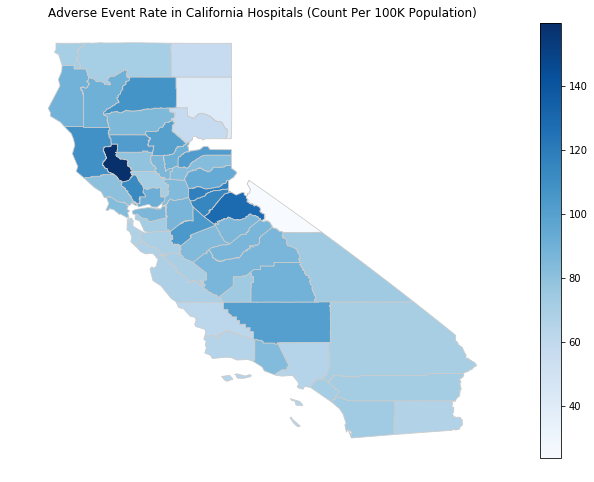

In [19]:
# Plotting our map.

mapmerge.plot(column=mapmerge['ObsRate'], cmap='Blues', linewidth=0.8, edgecolor='0.8', 
              legend=True, figsize=(15,8))

plt.title('Adverse Event Rate in California Hospitals (Count Per 100K Population)')

plt.axis('off')

plt.show()

This plot is easier to look at and quickly take in the data compared to our Plotly map. We can easily see where the event rate is higher in the country over the 10-year span and where there is a lower incident rate. However, it does lack the ability of being able to look at particular years and focusing on certain counties.

I did also take the time to animate this map by creating a gif outside of the notebook. You can see how the rate of adverse events have dropped in the state from the link below.

https://imgur.com/a/N0e9ApS

# Conclusion:
We aimed to answer a few questions with this data that I addressed in the beginning. By slicing up the data and making use of visualizations, we were able to answer these questions.

From our analysis we found:
- The overall rate of adverse events more than **halved** from *2005-2015*.
- **Perioperative Hemorrhage / Hematoma** and **Accidental Puncture / Laceration** are the events occuring most commonly from our data.
- **Lake County** has the highest count of events per 100K population from our data.